In [40]:
'''
Available methods are the followings:
[1] BetaCalibration
[2] ABM_BetaCal
[3] AB_BetaCal
[4] AM_BetaCal
[5] Sigmoid_Cal

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 20-09-2025

'''
import numpy as np
from collections import namedtuple
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import column_or_1d, check_consistent_length
from sklearn.utils.validation import check_array
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.exceptions import NotFittedError
from scipy.optimize import minimize_scalar
from sklearn.utils.validation import check_is_fitted

In [2]:
__all__ = ["BetaCalibration",
           "ABM_BetaCal",
           "AB_BetaCal",
           "AM_BetaCal", 
           "Sigmoid_Cal"]

In [3]:
class ValidateParams:
    
    '''Validate parameters'''
    
    def Interval(self, Param, Value, dtype=int, 
                 left=None, right=None, closed="both"):

        '''
        Validate numerical input.

        Parameters
        ----------
        Param : str
            Parameter's name

        Value : float or int
            Parameter's value

        dtype : {int, float}, default=int
            The type of input.

        left : float or int or None, default=None
            The left bound of the interval. None means left bound is -∞.

        right : float, int or None, default=None
            The right bound of the interval. None means right bound is +∞.

        closed : {"left", "right", "both", "neither"}
            Whether the interval is open or closed. Possible choices are:
            - "left": the interval is closed on the left and open on the 
              right. It is equivalent to the interval [ left, right ).
            - "right": the interval is closed on the right and open on the 
              left. It is equivalent to the interval ( left, right ].
            - "both": the interval is closed.
              It is equivalent to the interval [ left, right ].
            - "neither": the interval is open.
              It is equivalent to the interval ( left, right ).

        Returns
        -------
        Value : float or int
            Parameter's value

        '''
        Options = {"left"    : (np.greater_equal, np.less), # a<=x<b
                   "right"   : (np.greater, np.less_equal), # a<x<=b
                   "both"    : (np.greater_equal, np.less_equal), # a<=x<=b
                   "neither" : (np.greater, np.less)} # a<x<b

        f0, f1 = Options[closed]
        c0 = "[" if f0.__name__.find("eq")>-1 else "(" 
        c1 = "]" if f1.__name__.find("eq")>-1 else ")"
        v0 = "-∞" if left is None else str(dtype(left))
        v1 = "+∞" if right is None else str(dtype(right))
        if left  is None: left  = -np.inf
        if right is None: right = +np.inf
        interval = ", ".join([c0+v0, v1+c1])
        tuples = (Param, dtype.__name__, interval, Value)
        err_msg = "%s must be %s or in %s, got %s " % tuples    

        if isinstance(Value, dtype):
            if not (f0(Value, left) & f1(Value, right)):
                raise ValueError(err_msg)
        else: raise ValueError(err_msg)
        return Value

    def StrOptions(self, Param, Value, options, dtype=str):

        '''
        Validate string or boolean inputs.

        Parameters
        ----------
        Param : str
            Parameter's name
            
        Value : float or int
            Parameter's value

        options : set of str
            The set of valid strings.

        dtype : {str, bool}, default=str
            The type of input.
        
        Returns
        -------
        Value : float or int
            Parameter's value

        '''
        if Value not in options:
            err_msg = f'{Param} ({dtype.__name__}) must be either '
            for n,s in enumerate(options):
                if n<len(options)-1: err_msg += f'"{s}", '
                else: err_msg += f' or "{s}" , got %s'
            raise ValueError(err_msg % Value)
        return Value
    
    def check_range(self, param0, param1):
        
        '''
        Validate number range.
        
        Parameters
        ----------
        param0 : tuple(str, float)
            A lower bound parameter e.g. ("name", -100.)
            
        param1 : tuple(str, float)
            An upper bound parameter e.g. ("name", 100.)
            
        '''
        if param0[1] >= param1[1]:
            raise ValueError(f"`{param0[0]}` ({param0[1]}) must be less"
                             f" than `{param1[0]}` ({param1[1]}).")
            
    def check_y_inputs(self, y_proba, y_true=None):
        
        '''
        Validate inputs for calibration models.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Predicted probabilities ranges from 0 to 1.
            
        y_true : array-like, shape (n_samples,), default=None
            True binary labels (0/1).
            
        Returns
        -------
        y_proba : ndarray shape (n_samples,)
            Validated probabilities.
            
        y_true : ndarray shape (n_samples,)
            Validated labels. This returns None when `y_ture` is not 
            provided.
            
        '''
        # Ensure shapes
        y_proba = column_or_1d(y_proba)
        y_proba = check_array(y_proba, ensure_2d=False, dtype=float)

        # Probability range
        eps = np.finfo(float).eps
        y_proba = np.clip(y_proba, eps, 1 - eps)
        
        if y_true is not None:
            
            # Check lengths
            y_true = column_or_1d(y_true)
            check_consistent_length(y_proba, y_true)

            # Check that y_true only contains {0,1}
            unique_labels = np.unique(y_true)
            if not np.all(np.isin(unique_labels, [0, 1])):
                raise ValueError("`y_true` must be binary (0 or 1).")
            return y_proba, y_true
        
        else: return y_proba, None

In [4]:
class EvaluateLoss:
    
    '''
    Utility class to evaluate model performance before and after 
    calibration.

    Metrics:
        - Brier score
        - Log loss
        - Gini coefficient
        
    '''
    
    @staticmethod
    def _gini(y_true, y_proba):
        
        '''
        Compute Gini coefficient from ROC AUC.
        '''
        return 2 * roc_auc_score(y_true, y_proba) - 1

    def evaluate(self, y_true, y_proba, y_calib):
        
        '''
        Evaluate loss metrics before and after calibration.

        Parameters
        ----------
        y_true : array-like of shape (n_samples,)
            Ground truth binary labels.

        y_proba : array-like of shape (n_samples,)
            Predicted probabilities before calibration.

        y_calib : array-like of shape (n_samples,)
            Predicted probabilities after calibration.

        Returns
        -------
        losses : namedtuple
            Pre and post calibration losses (Brier score and log-loss)
            
        '''
        a, b = (y_true, y_proba), (y_true, y_calib)
        losses = {"brier_score": [float(brier_score_loss(*a)), 
                                  float(brier_score_loss(*b))],
                  "log_loss"   : [float(log_loss(*a)), 
                                  float(log_loss(*b))]}
        
        return namedtuple("Losses", losses.keys())(**losses)

In [5]:
class ABM_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with three parameters introduced in 
    Kull, M., Silva Filho, T.M. and Flach, P. (2017).
    Beta calibration: a well-founded and easily implemented 
    improvement on logistic calibration for binary classifiers.
    AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.

    Attributes
    ----------
    params_ : namedtuple
        Model coefficients: a, b, c (intercept), and m (midpoint).
        
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.log(np.hstack((X, 1.0 - X)))
        X[:, 1] *= -1
        
        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        kwargs = dict(C=1e12, penalty='l2', solver='lbfgs', fit_intercept=True)
        calibrator = LogisticRegression(**kwargs).fit(X, y, sample_weight)
        a, b = calibrator.coef_.ravel()
        self.index = [0,1]
        
        # Adjust if coefficients are negative
        if a < 0:
            self.index = [1]
            calibrator.fit(X[:,self.index], y, sample_weight)
            a, b = 0, calibrator.coef_.ravel()[0]
        elif b < 0:
            self.index = [0]
            calibrator.fit(X[:,self.index], y, sample_weight)
            a, b = calibrator.coef_.ravel()[0], 0

        c = calibrator.intercept_[0]
        m = minimize_scalar(lambda m : np.abs(b*np.log(1.-m)-a*np.log(m)-c),
                            bounds=[0, 1], method='Bounded').x

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        self.calibrator_ = calibrator
        y_calib = self.predict(y_proba)
        self.losses_ = self.evaluate(y, y_proba, y_calib)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])

        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X[:,self.index])[:,1]
        
        return y_calib

In [6]:
class AM_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with two parameters (a and m, fixing a = b)
    introduced in Kull, M., Silva Filho, T.M. and Flach, P. Beta 
    calibration:a well-founded and easily implemented improvement on 
    logistic calibration for binary classifiers. AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.

    Attributes
    ----------
    params_ : namedtuple
        Model coefficients: a, b, c (intercept), and m (midpoint).
        
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 1)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.log(X / (1. - X))
        
        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
         y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        kwargs = dict(C=1e12, penalty='l2', solver='lbfgs', fit_intercept=True)
        calibrator = LogisticRegression(**kwargs).fit(X, y, sample_weight)
        a = calibrator.coef_.ravel()[0]
        b = a 
        c = calibrator.intercept_[0]  
        m = 1.0 / (1.0 + np.exp(c / a)) 

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        self.calibrator_ = calibrator
        y_calib = self.predict(y_proba)
        self.losses_ = self.evaluate(y, y_proba, y_calib)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [7]:
class AB_BetaCal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Beta regression model with two parameters (a and b, fixing m = 0.5)
    introduced in Kull, M., Silva Filho, T.M. and Flach, P. Beta 
    calibration: a well-founded and easily implemented improvement on 
    logistic calibration for binary classifiers. AISTATS 2017.
    
    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.

    Attributes
    ----------
    params_ : namedtuple
        Model coefficients: a, b, c (intercept), and m (midpoint).
        
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)
        X = np.hstack((X, 1. - X))
        X = np.log(2 * X)

        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.

        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        kwargs = dict(C=1e12, penalty='l2', solver='lbfgs', fit_intercept=False)
        calibrator = LogisticRegression(**kwargs).fit(X, y, sample_weight)
        a, b = calibrator.coef_.ravel() * np.r_[1,-1]
        c = 0
        m = 0.5

        # Store related parameters
        values = {"a": float(a), "b": float(b), "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        self.calibrator_ = calibrator
        y_calib = self.predict(y_proba)
        self.losses_ = self.evaluate(y, y_proba, y_calib)
        
        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [8]:
class Sigmoid_Cal(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Platt’s scaling is a probability calibration method introduced by 
    John Platt (1999) to turn raw classifier scores into well
    calibrated probabilities. Given a raw score $f(x)$, Platt’s 
    scaling models the probability of class 1 as: 
    
                    P(y=1|x) = 1 / (1 + exp(A.(x) + B)

    Attributes
    ----------
    params_ : namedtuple
        Model coefficients: a, b, c (intercept), and m (midpoint).
        
    calib_ : sklearn.linear_model.LogisticRegression
        Internal logistic regression used to train the model.
        
    losses_ : namedtuple
        Pre and post calibration losses (Brier score and log-loss).

    '''
    
    def __transform__(self, y_proba):
        
        '''
        Transform probabilities into 2D-array for logistic regression.
        
        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        Returns
        -------
        X : array-like, shape (n_samples, 2)
            Transformed X.
        
        '''
        eps = np.finfo(float).eps
        X = np.clip(y_proba, eps, 1 - eps).reshape(-1,1)

        return X
    
    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        y_true : array-like, shape (n_samples,)
            Training data.
            
        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        # Validate inputs
        y_proba, y = self.check_y_inputs(y_proba, y_true)
        X = self.__transform__(y_proba)
     
        # Initial model fitting
        kwargs = dict(C=1e12, penalty='l2', solver='lbfgs', fit_intercept=True)
        calibrator = LogisticRegression(**kwargs).fit(X, y, sample_weight)
        a = calibrator.coef_.ravel()[0]
        b = 0
        c = calibrator.intercept_[0]  
        m = -c/a

        # Store related parameters
        values = {"a": float(a), "b": 0, "c": float(c), "m": float(m)}
        self.params_ = namedtuple("Parameters", values.keys())(**values)
        
        # Losses before and after calibration
        self.calibrator_ = calibrator
        y_calib = self.predict(y_proba)
        self.losses_ = self.evaluate(y, y_proba, y_calib)

        return self
    
    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.
            
        '''
        # Check if fit() was called
        check_is_fitted(self, ["params_", "calibrator_"])
            
        # Validate inputs
        y_proba, _ = self.check_y_inputs(y_proba, None)
        X = self.__transform__(y_proba)
        y_calib = self.calibrator_.predict_proba(X)[:,1]
        
        return y_calib

In [9]:
class BetaCalibration(BaseEstimator, RegressorMixin, ValidateParams, EvaluateLoss):
    
    '''
    Wrapper class for the three Beta regression models introduced in 
    Kull, M., Silva Filho, T.M. and Flach, P. Beta calibration: a 
    well-founded and easily implemented improvement on logistic 
    calibration for binary classifiers. AISTATS 2017.

    Note
    ----
    This implementation is adapted from the `betacal` Python library 
    (https://github.com/dirmeier/betacal) with modifications.

    Parameters
    ----------
    parameters : {"abm", "am", "ab", "sigmoid"}, default="abm"
        Determines which parameters will be calculated by the model. 

    Attributes
    ----------
    calibrator_ : sklearn.linear_model.LogisticRegression
        Internal calibration model corresponding to the chosen 
        parameterization.

    '''
   
    def __init__(self, parameters="abm"):
        
        params = {"abm": ABM_BetaCal(), "am": AM_BetaCal(), 
                  "ab": AB_BetaCal(), "sigmoid": Sigmoid_Cal()} 
        self.parameters = self.StrOptions("parameters", parameters, params.keys())
        self.calibrator_ = params[self.parameters]

    def fit(self, y_proba, y_true, sample_weight=None):
        
        '''
        Fit the model using y_proba, y_true as training data.

        Parameters
        ----------
        y_true : array-like, shape (n_samples,)
            Training data.

        y_proba : array-like, shape (n_samples,)
            Probability estimates.
            
        sample_weight : array-like, shape = (n_samples,), default=None 
            Sample weights. If None, then samples are equally weighted.

        Returns
        -------
        self : object
            Returns an instance of self.
            
        '''
        self.calibrator_.fit(y_proba, y_true, sample_weight)
        return self

    def predict(self, y_proba):
        
        '''
        Predict new values.

        Parameters
        ----------
        y_proba : array-like, shape (n_samples,)
            Probability estimates.

        Returns
        -------
        y_calib : array, shape (n_samples,)
            The predicted values.

        '''
        # Check if fit() was called
        check_is_fitted(self, "calibrator_")
        return self.calibrator_.predict(y_proba)

Parameters(a=0.4042760833483849, b=0.1573729226456932, c=-2.5330864622330997, m=0.9999940391390134)
Losses(brier_score=[0.03543610488671236, 0.016995220755660515], log_loss=[0.13450623678484486, 0.08185930309450648])


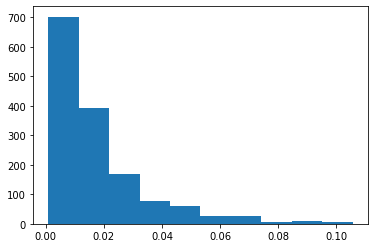

In [50]:
a = BetaCalibration("abm")
a.fit(probs_cal, y_cal)
print(a.calibrator_.params_)
print(a.calibrator_.losses_)
_ = plt.hist(a.predict(probs_cal))

Parameters(a=4.190402793717399, b=2.774682174703487, c=-5.596753143578118, m=0.8886780598411288)
Losses(brier_score=[0.00471240377987703, 2.053316954652412e-05], log_loss=[0.022577843084050125, 0.00023258099091412956])


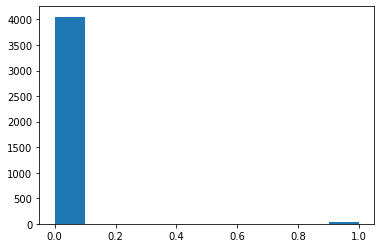

In [51]:
a = BetaCalibration("abm")
a.fit(probs_eval, y_eval)
print(a.calibrator_.params_)
print(a.calibrator_.losses_)
_ = plt.hist(a.predict(probs_eval))

In [45]:
a.predict(y_eval[y_eval==1])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
X = pd.read_csv('HL_online_fraud.csv')

In [11]:
X.head()

,dataset,raw_score,calibrated_score,quantiled_calibrated_score,target
0,train,0.000780,0.005857,-0.343981,0
1,train,0.000535,0.005847,-0.665472,0
2,train,0.002743,0.005876,0.009397,0
3,train,0.000077,0.005840,-1.299295,0
4,train,0.000686,0.005845,-0.824825,0


In [12]:
probs_cal = X.loc[X["dataset"]=="test","raw_score"].values
y_cal = X.loc[X["dataset"]=="test","target"].values
probs_eval = X.loc[X["dataset"]=="train","raw_score"].values
y_eval = X.loc[X["dataset"]=="train","target"].values